### DDPM : Energy Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from scipy import stats
from IPython.display import display, clear_output
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd
import numpy as np

# Load data with Date and Time columns
data = pd.read_csv('energy_data.csv')
features = data.drop(columns='date')

Code after taking diagnal element of the cov matrix

In [3]:
# The diffusion kernel returns the parameters of Pr(z_{t}|x)
def diffusion_kernel(x, t, beta,sigma_t):             # (current data points, current diffusion step, a noise parameter)
    alpha = np.power(1-beta,t)
    dk_mean = x * np.sqrt(alpha)                       # Mean of Diffusion Kernel
    dk_std = np.sqrt(beta * sigma_t)  # Extract standard deviations from diagonal of sigma_t
    return dk_mean, dk_std

# Beta  = Noise
# Alpha = Parameter which tell us about how much information to keep.   (alpha = 1 - Beta)

def conditional_diffusion_distribution(x, z_t, t, beta,sigma_t):    # Z_t  = Predicted value at current data point, t = current diffusion step,  beta = the noise parameter
    # Compute diffusion kernel parameters
    dk_mean, dk_std = diffusion_kernel(x, t, beta, sigma_t)
    
    # Compute conditional diffusion distribution parameters
    alpha = np.power(1 - beta, t)
    cd_mean = z_t / np.sqrt(alpha)  # Adjust the coefficient as needed          cd_mean = predicted mean at current step.
    cd_std = np.sqrt(beta * sigma_t)  # Extract standard deviations from diagonal of sigma_t
    return cd_mean, cd_std

def get_data_pairs(x_train, t, beta, sigma_t):


  # Extract diagonal elements (standard deviations) from sigma_t
  #sigma_t_diag = np.diag(sigma_t)  # Assuming sigma_t is a covariance matrix

  # Reshape sigma_t_diag for element-wise multiplication
  #sigma_t_reshaped = np.tile(sigma_t_diag, (x_train.shape[0], 1))

  # Find diffusion kernel for every x_train and draw samples (element-wise multiplication)
  dk_mean, dk_std = diffusion_kernel(x_train, t, beta, sigma_t)
  z_t = dk_std * np.random.normal(size=x_train.shape) + dk_mean

  # Find conditional diffusion distribution for each x_train, z pair and draw samples
  cd_mean, cd_std = conditional_diffusion_distribution(x_train, z_t, t, beta, sigma_t)

  if t == 1:
    z_tminus1 = x_train  # If first timestep, use the training data directly
  else:
    # Sample z_tminus1 using cd_std and cd_mean (element-wise multiplication)
    z_tminus1 = cd_std * np.random.normal(size=x_train.shape) + cd_mean

  return z_t, z_tminus1



In [4]:
class NonParametricModel():
    # Constructor initializes parameters
    def __init__(self):
        self.inc = 0.01
        self.max_val = 3.0
        self.model = []

    # Learns a model that predicts z_t_minus1 given z_t
    def train(self, zt, zt_minus1):
        zt = np.clip(zt, -self.max_val, self.max_val)
        zt_minus1 = np.clip(zt_minus1, -self.max_val, self.max_val)
        bins = np.arange(-self.max_val, self.max_val + self.inc, self.inc)
        numerator, _ = np.histogram(zt, bins=bins, weights=zt_minus1 - zt)
        denominator, _ = np.histogram(zt, bins=bins)
        self.model = numerator / (denominator + 1)

    def predict(self, zt):
        bin_index = np.floor((zt + self.max_val) / self.inc).astype('int')
        bin_index = np.clip(bin_index, 0, len(self.model) - 1)
        return zt + self.model[bin_index]


### Performing Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Create StandardScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the feature dataset
scaled_df = scaler.fit_transform(features)

# Convert scaled features back to DataFrame (if needed)
scaled_data = pd.DataFrame(scaled_df, columns=features.columns)

In [6]:
scaled_data.shape

(19735, 28)

In [7]:
# Assuming 'features' is your DataFrame without the 'Date' and 'Time' columns
cov_matrix = scaled_data.cov().to_numpy()
cov_matrix

array([[ 3.67240918e-02,  8.57207884e-03,  3.60413119e-03,
         3.61097195e-03,  7.33621565e-03, -2.65203839e-03,
         5.43379297e-03,  2.11573590e-03,  2.84136102e-03,
         1.20481402e-03,  1.33492804e-03,  3.61587157e-04,
         7.99289431e-03, -1.00408621e-02,  1.96656595e-03,
        -3.86759336e-03,  2.71608208e-03, -6.45297039e-03,
         8.04343624e-04, -3.38922278e-03,  6.49767939e-03,
        -2.30076660e-03, -1.14435181e-02,  5.84639637e-03,
         1.60207479e-05,  1.11686918e-03, -1.23867087e-03,
        -1.23867087e-03],
       [ 8.57207884e-03,  5.14121626e-02, -1.80951736e-03,
         5.31225261e-03, -4.06394181e-04,  2.64592480e-03,
        -7.36145518e-03,  9.04720552e-03, -7.39358437e-04,
         9.65756138e-03, -6.29436765e-03,  8.68839176e-03,
        -6.35331556e-03,  2.19611658e-02, -1.22061433e-02,
         2.88416135e-03, -5.80312232e-03,  1.04861577e-03,
        -1.49826243e-02, -6.83073086e-04, -5.77054275e-03,
        -8.25338715e-04,  6.09

In [8]:
# Extract the standard deviations from the diagonal of the covariance matrix
std_devs = np.sqrt(np.diag(cov_matrix))
std_devs

array([0.19163531, 0.2267425 , 0.33919021, 0.21902388, 0.31882339,
       0.22887689, 0.3333517 , 0.30421341, 0.36808729, 0.37057795,
       0.35253192, 0.27131218, 0.35455372, 0.6299253 , 0.39773672,
       0.36270979, 0.35816205, 0.35807818, 0.41929498, 0.343667  ,
       0.34195555, 0.34416003, 0.39213388, 0.35017437, 0.36291442,
       0.37960614, 0.57996734, 0.57996734])

In [9]:
scaled_data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [10]:
sigma_t = std_devs

In [11]:
x_train = scaled_data[['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2']].values

# Define model parameters
T = 2000    # Diffusion Steps
beta = 0.01511
#std_random_number = 1    # Old Covariance matrix
all_models = []
sigma_t_reshaped = np.tile(sigma_t, (x_train.shape[0], 1))

for t in range(0, T):
    clear_output(wait=True)

    
    display("Training timestep %d" % (t))
    zt, zt_minus1 = get_data_pairs(x_train, t + 1, beta, sigma_t_reshaped)
    all_models.append(NonParametricModel())
    # The model at index t maps data from z_{t+1} to z_{t}
    all_models[t].train(zt, zt_minus1)


'Training timestep 1999'

In [12]:
def sample(model, T, sigma_t, n_samples):                           
    samples = np.zeros((T + 1, n_samples, 28))  # Modify shape to include two features                       
    
    # Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T, :, :] = np.random.normal(size=(n_samples, 28))  # Generate samples for both features

    # For t = 100...99..98... ...0
    for t in range(T, 0, -1):
        clear_output(wait=True)
        display("Predicting z_{%d} from z_{%d}" % (t - 1, t))
        # Predict samples[t-1,:] from samples[t,:] using the appropriate model
        model_t_minus_1 = model[t - 1]
        samples[t - 1, :, :] = model_t_minus_1.predict(samples[t, :])

        # If not the last time step
        if t > 0:
            # Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
            noise = np.random.normal(0, sigma_t[t - 1], size=(n_samples, 28))  # Generate noise for both features
            samples[t - 1, :, :] += noise

    return samples  # Return the samples array containing the generated data for each diffusion step


'Predicting z_{0} from z_{1}'

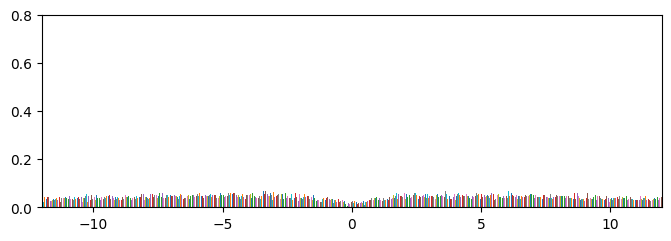

In [13]:
# Assuming T is the number of diffusion steps
T = 800

# Define your sigma_t as a list of standard deviations for each diffusion step
sigma_t

# Repeat the standard deviations to cover all diffusion steps
sigma_t = np.tile(sigma_t, (T // len(sigma_t)) + 1)[:T]

# Convert sigma_t to a numpy array for compatibility with the sample function
sigma_t = np.array(sigma_t)

n_samples = 19735       # Specifies the number of samples to generate using the model.
samples = sample(all_models, T, sigma_t, n_samples) # Call the samples function to generate the new samples


# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-12,12.05,0.05)   # This line defines the bins for the histogram plot, ranging from -3 to 3 with a step size of 0.05.

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-12,12])
plt.hist(sampled_data, bins=bins, density =True)   # This line plots the histogram of the sampled data using the defined bins. The density=True argument normalizes the histogram to form a probability density.
# plt.hist(sampled_data, density =True) 
ax.set_ylim(0, 0.8)    # This line sets the y-axis limits.
plt.show()


In [14]:
synthetic_data = pd.DataFrame(sampled_data, columns=features.columns)
df_actual = scaled_data

In [15]:
synthetic_data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,0.535473,-9.498761,1.222885,-8.971990,-23.493351,8.461486,4.569841,-0.624547,22.993667,-2.502730,...,-2.744779,11.295176,-12.471567,-6.123067,-5.769021,-1.827324,-7.347414,10.942999,-6.901520,14.462061
1,-16.870188,5.374513,-13.586147,3.386408,2.979796,3.989872,-2.903774,13.849942,12.127451,11.653321,...,14.124143,-7.840365,17.413932,3.643779,13.976631,-14.739734,-0.117889,-5.145512,20.184276,15.237006
2,6.286772,-8.500103,-27.625172,-4.596969,-27.098290,-5.969535,-8.559867,-6.118257,-6.102867,8.233017,...,5.941673,11.592323,4.300997,-9.102355,11.331809,10.584277,-12.447977,0.846447,-1.303384,11.766528
3,18.441634,1.985537,9.538585,1.020445,-10.927199,12.041626,-7.683030,1.308910,3.677574,3.823249,...,3.172569,10.620135,10.312926,-19.843930,-7.599094,-8.323166,-0.052090,-13.925508,-14.841910,-10.601566
4,-11.345146,10.827323,5.748962,-8.454363,2.248496,-2.432730,-10.394083,-1.673932,-19.747689,5.356851,...,3.419728,6.206628,9.528800,-7.145304,-3.303971,-6.240702,-9.065452,11.227320,7.364798,-8.589946


In [16]:
df_actual.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,-0.906542,-0.142857,-0.345301,0.132373,-0.549309,0.368076,-0.569624,0.492133,-0.297297,0.528525,...,-0.553937,0.354581,-0.254019,-0.804651,0.789474,0.000000,0.907692,0.076923,-0.469102,-0.469102
1,-0.906542,-0.142857,-0.345301,0.082653,-0.549309,0.364280,-0.569624,0.497741,-0.297297,0.564874,...,-0.547000,0.357064,-0.261522,-0.800000,0.789474,-0.047619,0.789744,0.067873,-0.255834,-0.255834
2,-0.925234,-0.142857,-0.345301,0.061004,-0.549309,0.358890,-0.569624,0.511139,-0.310511,0.556125,...,-0.560874,0.352097,-0.269025,-0.795349,0.789474,-0.095238,0.671795,0.058824,0.145695,0.145695
3,-0.925234,0.142857,-0.345301,0.048161,-0.549309,0.356828,-0.569624,0.517370,-0.317117,0.541898,...,-0.560874,0.343819,-0.276527,-0.790698,0.789474,-0.142857,0.553846,0.049774,0.816522,0.816522
4,-0.906542,0.142857,-0.345301,0.062838,-0.549309,0.353454,-0.569624,0.517370,-0.317117,0.525395,...,-0.560874,0.343819,-0.284030,-0.786047,0.789474,-0.190476,0.435897,0.040724,-0.596778,-0.596778


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Create StandardScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the feature dataset
scaled_synthetic = scaler.fit_transform(synthetic_data)

# Convert scaled features back to DataFrame (if needed)
df_synthetic = pd.DataFrame(scaled_synthetic, columns=synthetic_data.columns)

In [18]:
df_synthetic.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,0.021707,-0.179710,-0.002017,-0.175074,-0.554104,0.202659,0.111905,-0.030067,0.537138,-0.076251,...,-0.007284,0.293590,-0.317848,-0.148089,-0.182640,-0.062851,-0.141826,0.243145,-0.168714,0.308717
1,-0.345545,0.145400,-0.360571,0.103605,0.060826,0.090134,-0.060585,0.319422,0.282347,0.242369,...,0.389493,-0.163074,0.367823,0.074994,0.275853,-0.352456,0.030008,-0.116823,0.489244,0.326429
2,0.143057,-0.157881,-0.700481,-0.076418,-0.637841,-0.160486,-0.191127,-0.162714,-0.145117,0.165386,...,0.197031,0.300682,0.066970,-0.216138,0.214441,0.215521,-0.263059,0.017243,-0.032727,0.247107
3,0.399519,0.071322,0.199321,0.050253,-0.262212,0.292750,-0.170890,0.016616,0.084215,0.066133,...,0.131899,0.277481,0.204903,-0.461485,-0.225134,-0.208543,0.031572,-0.313269,-0.361599,-0.264144
4,-0.228969,0.264592,0.107567,-0.163401,0.043839,-0.071485,-0.233461,-0.055405,-0.465061,0.100650,...,0.137712,0.172153,0.186913,-0.171438,-0.125402,-0.161836,-0.182661,0.249507,0.177838,-0.218166


### PCA Plot

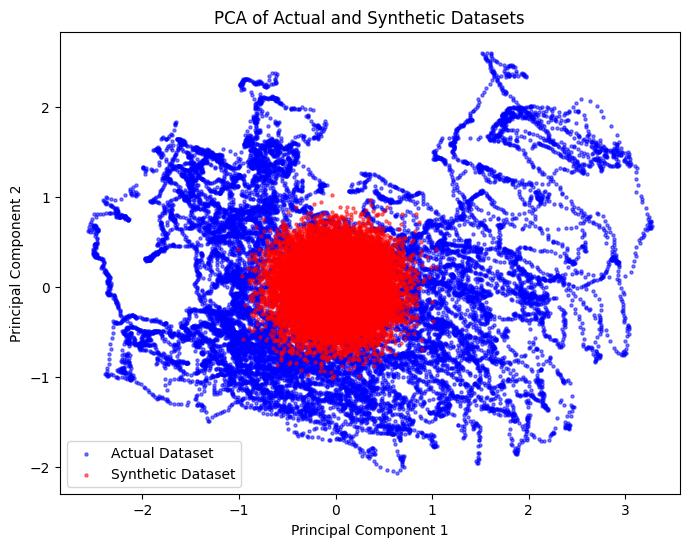

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df_actual and df_synthetic are already defined


# Perform PCA on the actual dataset
pca = PCA(n_components=2)
principal_components_1 = pca.fit_transform(df_actual)

# Perform PCA on the synthetic dataset
principal_components_2 = pca.fit_transform(df_synthetic)

# Plot both datasets on the same graph with different colors
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_1[:, 0], principal_components_1[:, 1], s=5, alpha=0.5, label='Actual Dataset', color='blue')
plt.scatter(principal_components_2[:, 0], principal_components_2[:, 1], s=5, alpha=0.5, label='Synthetic Dataset', color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Actual and Synthetic Datasets')
plt.legend()
plt.show()

### Distance Metrics

In [20]:
from IPython.display import SVG, display, Image
import numpy as np
import sklearn
import copy
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import tsgm

import numpy as np
import functools
import sklearn
import os

statistics = [
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=1),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=1)]

In [21]:
discrepancy_func = lambda x, y: np.linalg.norm(x - y)

In [22]:
dist_metric = tsgm.metrics.DistanceMetric(
    statistics=statistics, discrepancy=discrepancy_func
)
print(dist_metric(df_actual, df_synthetic))

3.1401849173675503e-16


### Distributions

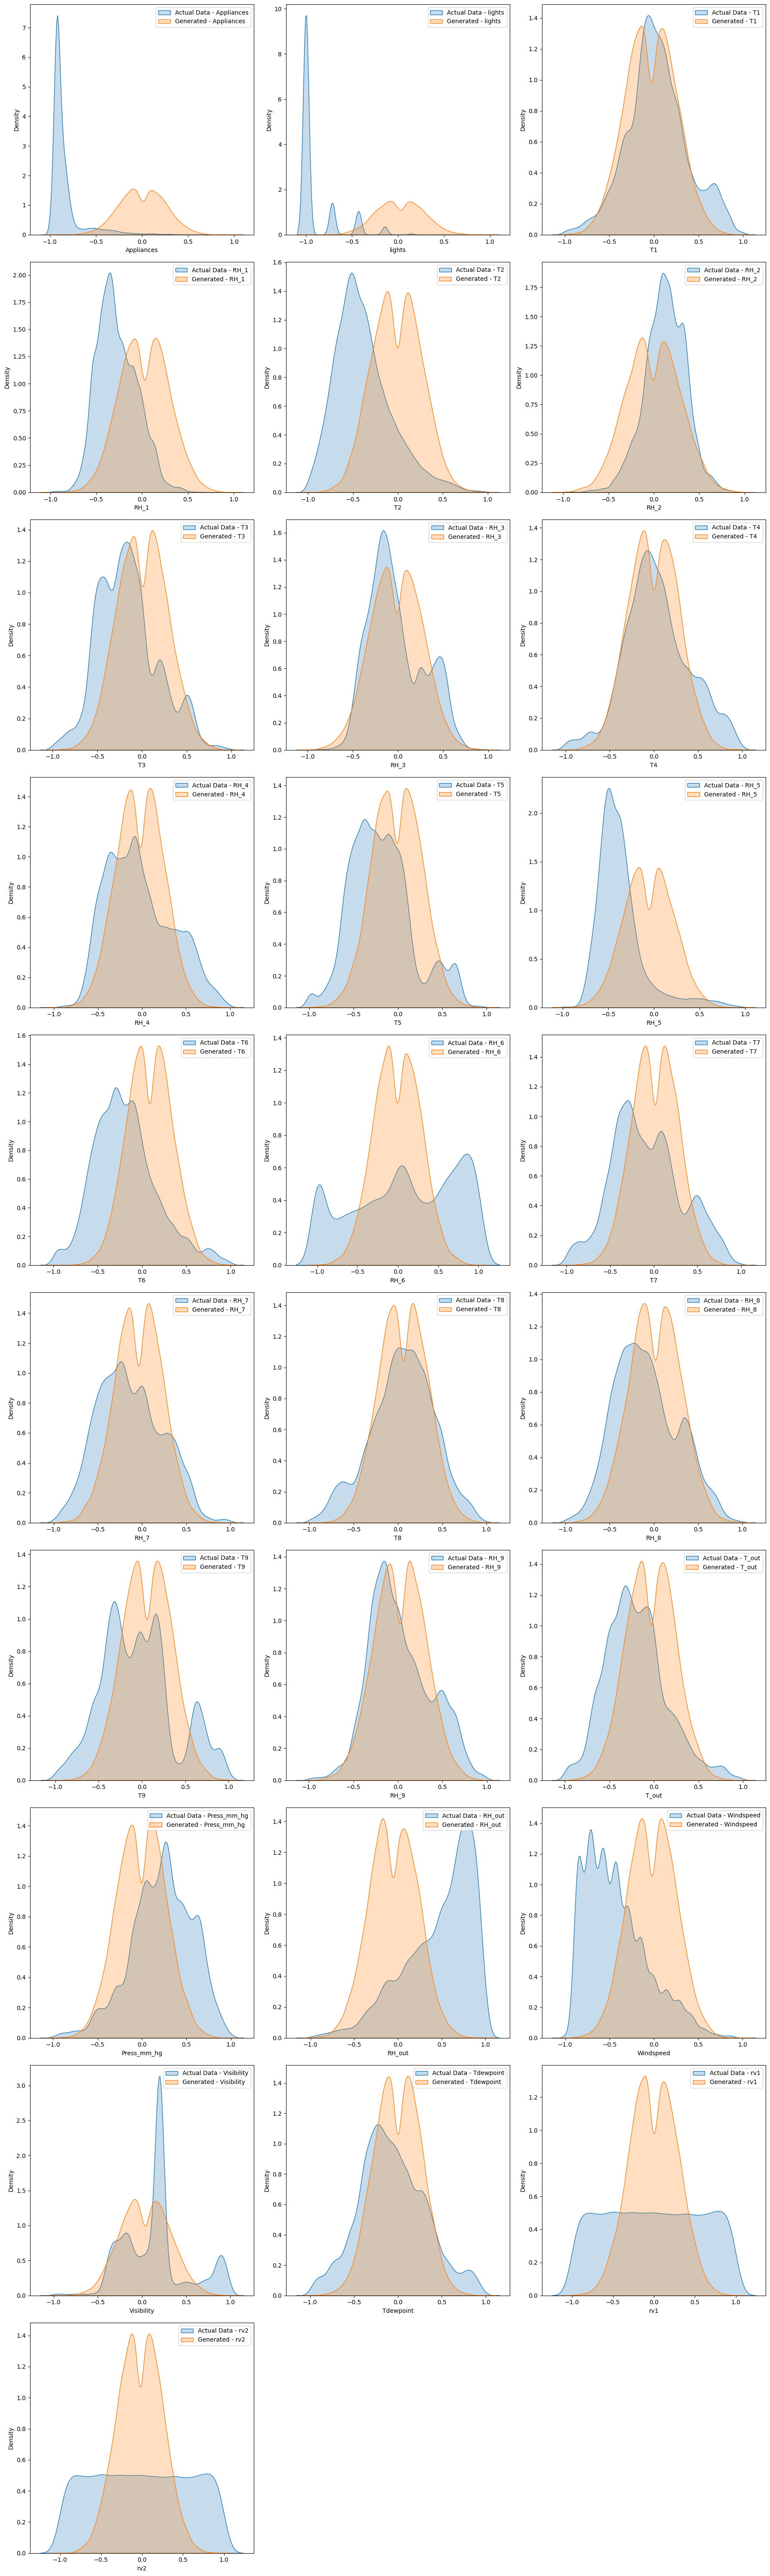

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np

# Assuming df_actual and df_synthetic are your DataFrames

# Initialize a list to store KL Divergence scores
kl_divergences = []

# Number of features
num_features = len(df_actual.columns)

# Calculate the number of rows needed (3 graphs per row)
num_rows = int(np.ceil(num_features / 3))

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature and corresponding subplot axis
for i, feature in enumerate(df_actual.columns):
    sns.kdeplot(df_actual[feature], label=f'Actual Data - {feature}', fill=True, ax=axes[i])
    sns.kdeplot(df_synthetic[feature], label=f'Generated - {feature}', fill=True, ax=axes[i])
    
    # Calculate KL Divergence
    # kl_divergence = entropy(df_actual[feature], df_synthetic[feature])
    #kl_divergences.append(kl_divergence)
    
    # Add title and legend
    # axes[i].set_title(f'Distribution of {feature} (KL Divergence: {kl_divergence:.4f})')
    axes[i].legend()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
